In [76]:
import qiime2
from qiime2.plugins import (
    demux, dada2, feature_table, metadata, 
    greengenes2, taxa
)

from qiime2 import Artifact
import os

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

path = {
    "art" : "../data/artifacts/",
    "vis" : "../visualizations/",
}

for filepath in path.values():
    os.makedirs(filepath, exist_ok=True)

# 1. Quality control 

Clearing sequences from artifacts of sequencing

In [23]:
# import raw data with manifest 
raw_seqs = qiime2.Artifact.import_data('SampleData[PairedEndSequencesWithQuality]', '../data/manifest.tsv', view_type='PairedEndFastqManifestPhred33V2')

In [24]:
quality_vis = demux.visualizers.summarize(raw_seqs)

/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/qiime2-2023.2/lib/python3.8/site-packages/q2_demux/_summarize/_visualizer.py:191: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  context['result_data'] = context['result_data'].append(df)
/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/qiime2-2023.2/lib/python3.8/site-packages/q2_demux/_summarize/_visualizer.py:191: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  context['result_data'] = context['result_data'].append(df)


In [73]:
quality_vis.visualization.save(path["vis"] + "quality-plot.qzv")

'../visualizations/quality-plot.qzv'

In [ ]:
qc_reads = dada2.methods.denoise_paired(raw_seqs, trunc_len_f=260, trunc_len_r=200, n_threads=8)

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: run_dada.R --input_directory /tmp/tmpot2ct8fo/forward --input_directory_reverse /tmp/tmpot2ct8fo/reverse --output_path /tmp/tmpot2ct8fo/output.tsv.biom --output_track /tmp/tmpot2ct8fo/track.tsv --filtered_directory /tmp/tmpot2ct8fo/filt_f --filtered_directory_reverse /tmp/tmpot2ct8fo/filt_r --truncation_length 260 --truncation_length_reverse 200 --trim_left 0 --trim_left_reverse 0 --max_expected_errors 2.0 --max_expected_errors_reverse 2.0 --truncation_quality_score 2 --min_overlap 12 --pooling_method independent --chimera_method consensus --min_parental_fold 1.0 --allow_one_off False --num_threads 8 --learn_min_reads 1000000



R version 4.2.2 (2022-10-31) 


Loading required package: Rcpp


DADA2: 1.26.0 / Rcpp: 1.0.10 / RcppParallel: 5.1.6 
2) Filtering ............
3) Learning Error Rates
89318840 total bases in 343534 reads from 12 samples will be used for learning the error rates.
68706800 total bases in 343534 reads from 12 samples will be used for learning the error rates.
3) Denoise samples ............
............
5) Remove chimeras (method = consensus)
6) Report read numbers through the pipeline
7) Write output


In [ ]:
qc_reads.denoising_stats.save(path["art"] + "denoise-stats.qza")
qc_reads.table.save(path["art"] + "feature-table.qza")
qc_reads.representative_sequences.save(path["art"] + "rep-seqs.qza")

'../data/artifacts/rep-seqs.qza'

In [ ]:
feature_table.visualizers.summarize(qc_reads.table).visualization.save(path["vis"] + "feature-table.qzv")

'../visualizations/feature-table.qzv'

# 2. Taxonomical classification

In [26]:
# load preprocessed data
table = Artifact.load(path["art"] + "feature-table.qza")
rep_seqs = Artifact.load(path["art"] + "rep-seqs.qza")

## 2.1 Greengenes 2 - [publication](https://www.nature.com/articles/s41587-023-01845-1)

In [5]:
from qiime2.plugins import vsearch

gg2_mapped = vsearch.methods.cluster_features_closed_reference(sequences=rep_seqs, table=table,
                                                               reference_sequences=Artifact.load(path["art"] + "2022.10.backbone.full-length.fna.qza"),
                                                               perc_identity=0.99, threads=8)

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/tmptuaddvw2 --id 0.99 --db /tmp/qiime2/vbezshapkin/data/a53d9300-5c5c-4774-a2e8-a5e23904f1ae/data/dna-sequences.fasta --uc /tmp/tmpibu6kuwl --strand plus --qmask none --notmatched /tmp/tmpqr9_h8k2 --threads 8 --minseqlength 1 --fasta_width 0



vsearch v2.22.1_linux_x86_64, 1007.1GB RAM, 144 cores
https://github.com/torognes/vsearch

Reading file /tmp/qiime2/vbezshapkin/data/a53d9300-5c5c-4774-a2e8-a5e23904f1ae/data/dna-sequences.fasta 100%
494630940 nt in 331269 seqs, min 416, max 4563, avg 1493
Masking 100%
Counting k-mers 100%
Creating k-mer index 100%
Searching 100%
Matching unique query sequences: 187 of 620 (30.16%)


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --sortbysize /tmp/tmpqr9_h8k2 --xsize --output /tmp/q2-DNAFASTAFormat-qd5kytpe --minseqlength 1 --fasta_width 0



vsearch v2.22.1_linux_x86_64, 1007.1GB RAM, 144 cores
https://github.com/torognes/vsearch

Reading file /tmp/tmpqr9_h8k2 100%
151636 nt in 433 seqs, min 260, max 448, avg 350
Getting sizes 100%
Sorting 100%
Median abundance: 14
Writing output 100%


In [18]:
gg2_mapped.clustered_table.save("../data/artifacts/feature-table-gg2.qza")
gg2_mapped.clustered_sequences.save("../data/artifacts/rep-seqs-gg2.qza")

'../data/artifacts/rep-seqs-gg2.qza'

In [8]:
# percentage of unmapped sequences 

unmapped_perc = gg2_mapped.unmatched_sequences.view(pd.Series).shape[0] + rep_seqs.view(pd.Series).shape[0]
print('Percentage of unmapped sequences: {:.2f}%'.format(unmapped_perc*100))

Percentage of unmapped sequences: 69.84%


## Best `Blastn` hits on unmapped sequences: 

1. Homo sapiens mutS homolog 3 (MSH3), RefSeqGene on chromosome 5
2. Homo sapiens isolate CHM13 chromosome 17
3. Homo sapiens mutS homolog 3 (MSH3), RefSeqGene on chromosome 5
4. Uncultured bacterium clone OTU_105 16S ribosomal RNA gene, partial sequence
5. Picea glauca isolate WS77111 chloroplast, complete genome (Świerk biały :D)

70% sekwencji nie pochodzi od bakterii, tylko od innych rzeczy (człowiek, jakieś inne rzeczy z nosa)

# Relative abundance of unmapped reads

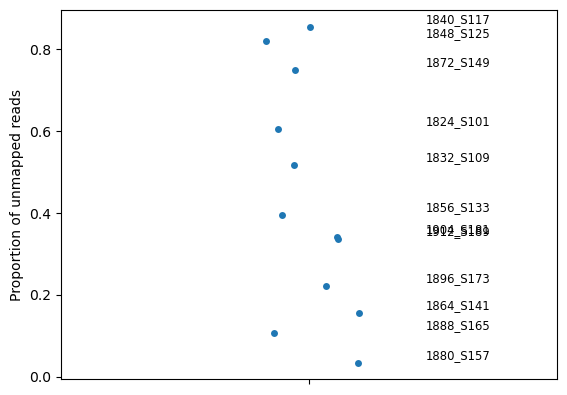

In [68]:
# count percentage in rows
rel_abundance_df = table.view(pd.DataFrame)
rel_abundance_df = rel_abundance_df.div(rel_abundance_df.sum(axis=1), axis=0)
unmapped = gg2_mapped.unmatched_sequences.view(pd.Series).index
# calculate percentage of unmapped in each row 
rel_abundance_df['unmapped'] = rel_abundance_df[unmapped].sum(axis=1)
# plot kdeplot of results
g = sns.stripplot(rel_abundance_df['unmapped'])
g.set(ylabel="Proportion of unmapped reads")
# add sample names over points
for i, point in enumerate(rel_abundance_df['unmapped'].index):
    g.text(0.3, rel_abundance_df['unmapped'][i]+0.01, rel_abundance_df['unmapped'].index[i], horizontalalignment='center', size='small', 
           color='black')

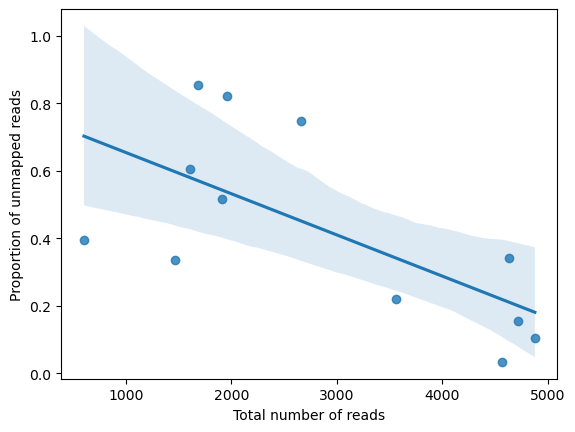

In [107]:
data = pd.concat([table.view(pd.DataFrame).sum(axis=1), rel_abundance_df["unmapped"]], axis=1)
data.columns = ["total", "unmapped"]
g = sns.regplot(x="total", y="unmapped", data=data, fit_reg=True)
g.set(xlabel="Total number of reads", ylabel="Proportion of unmapped reads");

In [102]:
rel_abundance_df["unmapped"]

1824_S101    0.603856
1832_S109    0.516971
1840_S117    0.854772
1848_S125    0.820408
1856_S133    0.395349
1864_S141    0.154986
1872_S149    0.748687
1880_S157    0.034158
1888_S165    0.105943
1896_S173    0.221786
1904_S181    0.340448
1912_S189    0.335607
Name: unmapped, dtype: float64

In [14]:
!wget -O ../data/artifacts/gg2.2022.10.taxonomy.asv.nwk.qza http://ftp.microbio.me/greengenes_release/2022.10/2022.10.taxonomy.asv.nwk.qza

--2023-08-01 15:26:46--  http://ftp.microbio.me/greengenes_release/2022.10/2022.10.taxonomy.asv.nwk.qza
Resolving ftp.microbio.me (ftp.microbio.me)... 169.228.46.98
Connecting to ftp.microbio.me (ftp.microbio.me)|169.228.46.98|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 193668351 (185M)
Saving to: ‘../data/artifacts/gg2.2022.10.taxonomy.asv.nwk.qza’

../data/artifacts/g 100%[===================>] 184.70M  14.6MB/s    in 13s     

2023-08-01 15:26:59 (14.5 MB/s) - ‘../data/artifacts/gg2.2022.10.taxonomy.asv.nwk.qza’ saved [193668351/193668351]



In [15]:
tax = greengenes2.methods.taxonomy_from_table(table = gg2_mapped.clustered_table,
                                              reference_taxonomy = Artifact.load(path["art"] + "g2.2022.10.taxonomy.asv.nwk.qza"))

In [19]:
tax.classification.save(path["art"] + "tax-gg2.qza")

'../data/artifacts/tax-gg2.qza'

In [84]:
vis = taxa.visualizers.barplot(table=gg2_mapped.clustered_table,
                               taxonomy=tax.classification)
vis.visualization.save(path["vis"] + "gg2-barplot.qzv")

'../visualizations/gg2-barplot.qzv'